Back to the main [Index](../index.ipynb) <a id="top"></a>

# $G_0W_0$ band structure with star-function interpolation
[[back to top](#top)]

Standard functionals (LDA and GGA), systematically underestimate band gaps, giving values
that are about 30-40% smaller than experimental data.
The inability of standard Kohn-Sham (KS) theory to give band gaps close to experiment is often referred to as the **band-gap problem**.

From a theoretical point of view this is not surprising since KS eigenvalues are not supposed to give the correct band energies.
The band structure of a crystal is rigorously defined as the energies needed to add or subtract electrons from the many-body system
which, in turn, are related to the difference between total energies of **many-body states** differing by one electron.

An alternative, more traditional, approach to the study of exchange-correlation effects in
many-body systems is provided by Many-Body Perturbation Theory (MBPT) which defines a rigorous approach to the description of excited-state properties, based on the Green's function formalism.
In this lesson, we discuss how to use the MBPT part of ABINIT to compute the band-structure of silicon
within the so-called $G_0W_0$ approximation.
For a very brief introduction to the many-body formalism, please consult the 
[MBPT_notes](https://docs.abinit.org/theory/mbt/)

### Related ABINIT variables

    * optdriver
    * ecuteps
    * ecutsigx
    * nband
    * gwcalctyp
    * gw_qprange
    * all gw** variables
    
## Table of Contents
[[back to top](#top)]

- [Description of the lesson](#Description-of-the-lesson)
- [Analysis of the results](#Analysis-of-the-results)
- [Interpolating the QP corrections](#Interpolating-the-QP-corrections)

## Description of the lesson
[[back to top](#top)]

In this lesson, we construct an AbiPy flow made of two works.
The first work is a standard KS band-structure calculation consisting of
an initial GS calculation to get the density followed by two NSCF calculations.
The first NSCF task computes the KS eigenvalues on a high-symmetry path in the BZ,
whereas the second NSCF task employs a homogeneous k-mesh so that one can compute
the DOS from the KS eigenvalues.

The second work represents the real GW workflow that uses the density computed in the first task of
the previous work to compute the KS bands for *many empty states*.
The WFK file produced in this step is then used to compute the screened interaction $W$.
Finally, we perform a self-energy calculation that uses the $W$ produced
in the previous step and the WFK file to compute the matrix elements of the self-energy and
the $G_0W_0$ corrections for all the k-points in the IBZ and 8 bands (4 occupied + 4 empty)
Once the flow is completed, we can interpolate the $G_0W_0$ corrections.

Don't worry if there are steps of the entire procedure that are not clear to you.
$GW$ calculations are much more complicated than standard KS band structures and
the main goal of this lesson is to give you an overview of the Abipy capabilities.

Let's start with the usual import section:

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np
import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook

import abipy.flowtk as flowtk

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

and now we import the `make_inputs` function that generates the inputs files required by our `Flow`.
Let's have a look at the code:

In [2]:
from lesson_g0w0 import make_inputs
abilab.print_source(make_inputs)

Ok the function is a little bit long but it's normal since we are running different kind of calculations,
each step has its own set of variables and $GW$ calculations are much more difficult than standard KS calculations!

If there are variables whose meaning is not clear to you, please take some time to read the Abinit documentation
and the standard $GW$ tutorials before proceeding.
For your convenience, we report the variables used to compute the screening and the electron self-energy

In [3]:
scf, bands_nscf, dos_nscf, gw_nscf, scr, sig = make_inputs(ngkpt=(2, 2, 2))

#### Input for RPA screening calculation

In [4]:
scr

<AbinitInput at 4651272568>

#### Input for self-energy calculation with plasmon-pole model

In [5]:
sig

<AbinitInput at 4651310328>

Now we can use the 4 inputs file produced by `make_inputs` to generate our $GW$ flow.
The tricky part is represented by the connections among the tasks in the $GW$ part. 

In [6]:
from lesson_g0w0 import build_g0w0_flow
abilab.print_source(build_g0w0_flow)

Let's build the flow:

In [7]:
flow = build_g0w0_flow()

and visualize the connections with:

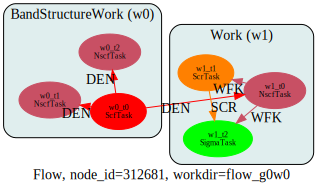

In [8]:
flow.get_graphviz()

In [9]:
#flow.plot_networkx(with_edge_labels=True);

As you can see, we have 2 works:

In [10]:
for i, work in enumerate(flow): 
    print("[%d] %s" % (i, work))

[0] <BandStructureWork, node_id=312682, workdir=flow_g0w0/w0>
[1] <Work, node_id=312686, workdir=flow_g0w0/w1>


As promised, the first work has 3 standard KS tasks:

In [11]:
for task in flow[0]: 
    print(task)

<ScfTask, node_id=312683, workdir=flow_g0w0/w0/t0>
<NscfTask, node_id=312684, workdir=flow_g0w0/w0/t1>
<NscfTask, node_id=312685, workdir=flow_g0w0/w0/t2>


while the second work contains the tasks required for $GW$:

In [12]:
for task in flow[1]: 
    print(task)

<NscfTask, node_id=312687, workdir=flow_g0w0/w1/t0>
<ScrTask, node_id=312688, workdir=flow_g0w0/w1/t1>
<SigmaTask, node_id=312689, workdir=flow_g0w0/w1/t2>


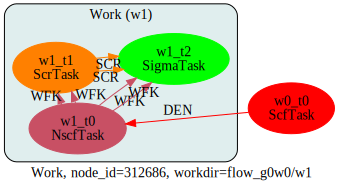

In [13]:
flow[1].get_graphviz()

Now you can execute the lesson_g0w0.py script to generate the flow  and then use:

    abirun.py flow_g0w0 scheduler
    
<div class="alert alert-warning">
Please make sure that AbiPy is properly configured by running abicheck --with flow
</div>

Alternatively, one can use the files in the github repository and use AbipY 
to analyze the data.

## Analysis of the results
[[back to top](#top)]

Let's start with the KS results stored in the `GSR.nc` files:

In [15]:
!find flow_g0w0 -name "*_GSR.nc"

flow_g0w0/w0/t0/outdata/out_GSR.nc
flow_g0w0/w0/t1/outdata/out_GSR.nc
flow_g0w0/w0/t2/outdata/out_GSR.nc
flow_g0w0/w1/t0/outdata/out_GSR.nc


You are already an AbiPy guru so it should be clear that to plot the KS band structure with the KS DOS we just need:

<IPython.core.display.Javascript object>


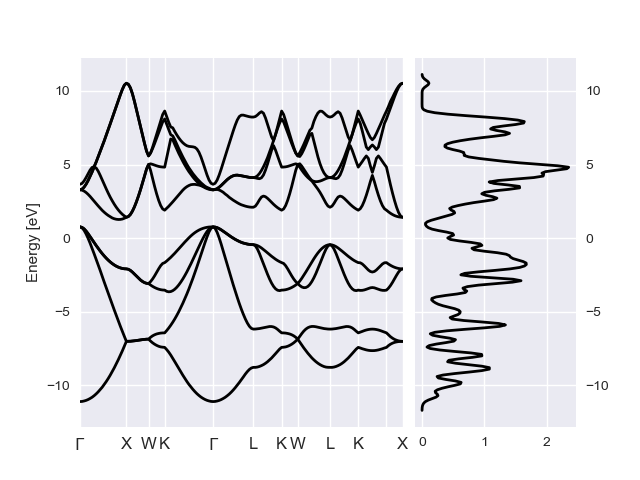

In [16]:
 with abilab.abiopen("flow_g0w0/w0/t1/outdata/out_GSR.nc") as gsr:
    ks_ebands_kpath = gsr.ebands
    
with abilab.abiopen("flow_g0w0/w0/t2/outdata/out_GSR.nc") as gsr:
    ks_ebands_kmesh = gsr.ebands
    
ks_edos = ks_ebands_kmesh.get_edos()
ks_ebands_kpath.plot_with_edos(ks_edos);

All is going well so far.
We obtained the KS band structure with the infamous band-gap problem.
Now let's turn our attention to the $GW$ results produced by the `SigmaTask` in the `SIGRES.nc` file:

In [17]:
!find flow_g0w0 -name "*_SIGRES.nc"

flow_g0w0/w1/t2/outdata/out_SIGRES.nc


Open the file with:

In [18]:
sigres = abilab.abiopen("flow_g0w0/w1/t2/outdata/out_SIGRES.nc") 

and extract a pandas `DataFrame` with the QP results at the $\Gamma$ point with:

In [19]:
qpdata_gamma = sigres.get_dataframe_sk(spin=0, kpoint=(0, 0, 0), ignore_imag=True)
qpdata_gamma.keys()

Index(['spin', 'kpoint', 'band', 'e0', 'qpe', 'qpe_diago', 'vxcme', 'sigxme',
       'sigcmee0', 'vUme', 'ze0', 'qpeme0', 'nsppol', 'nspinor', 'nspden',
       'nband', 'nkpt', 'ecutwfn', 'ecuteps', 'ecutsigx', 'scr_nband',
       'sigma_nband', 'gwcalctyp', 'scissor_ene'],
      dtype='object')

The `DataFrame` contains $GW$ results as well as input parameters useful for convergence studies.

- *spin*: spin index (C convention, i.e >= 0)
- *band*: band index. (C convention, i.e >= 0).
- *e0*: Initial KS energy.
- *qpe*: Quasiparticle energy (complex) computed with the perturbative approach.
- *qpe_diago*: Quasiparticle energy (real) computed by diagonalizing the self-energy.
- *vxcme*: Matrix element of $v_{\text{xc}}[n_{\text{val}}]$ with $n_{\text{val}}$ the valence charge density.
- *sigxme*: Matrix element of $\Sigma_x$.
- *sigcmee0*: Matrix element of $\Sigma_c(e_0)$ with $e_0$ being the KS energy.
- *vUme*: Matrix element of the vU term of the LDA+U Hamiltonian.
- *ze0*: Renormalization factor computed at $e = e_0$.
- *qpeme0*: QP correction i.e. $e_{\text{QP}} - e_{0}$

Note that some quantities are complex but since we are not interested in lifetimes (that by the way are not correctly described by the plasmon-pole approximation), we ignored the imaginary part with `ignore_imag`.

Let's print a subset of columns with:

In [20]:
qpdata_gamma[['e0', 'qpe', 'vxcme', 'sigxme', 'sigcmee0', 'ze0', 'qpeme0']].round(decimals=3)

,e0,qpe,vxcme,sigxme,sigcmee0,ze0,qpeme0
0,-6.232,-5.693,-10.362,-17.428,7.925,0.629,0.540
1,5.633,6.264,-11.160,-13.117,2.755,0.790,0.631
2,5.633,6.264,-11.160,-13.117,2.755,0.790,0.631
3,5.633,6.264,-11.160,-13.117,2.755,0.790,0.631
4,8.148,9.444,-9.967,-5.517,-2.817,0.793,1.296
5,8.148,9.444,-9.967,-5.517,-2.817,0.793,1.296
6,8.148,9.444,-9.967,-5.517,-2.817,0.793,1.296
7,8.526,9.980,-10.766,-5.897,-3.037,0.793,1.454


To plot the QP data as function of the initial KS energy, use:

<IPython.core.display.Javascript object>


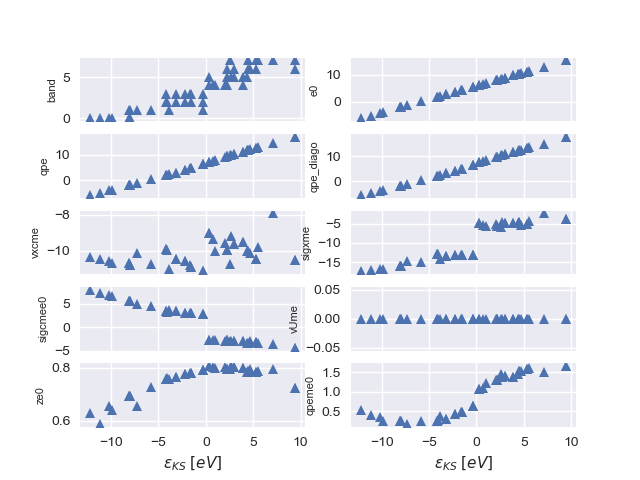

KS Fermi energy at: 5.958515778044983 eV


In [21]:
sigres.plot_qps_vs_e0();
print("KS Fermi energy at:", sigres.ebands.fermie, "eV")

This figure gives us the opportunity to discuss several important points.

First of all the QP correction (`qpeme0`) are rather smooth so one can try to interpolate the data 
with some kind of interpolation algorithm. 

Note how valence and conduction states are affected in a different way by the self-energy.
As expected, the matrix elements of the exchange part `sigxme` 
(a.k.a Fock operator in Hartree-Fock theory) are always negative but they also show a "jump" across the Fermi level.
A similar jump is observed in the matrix elements of the correlation part `sigcmee0`.
These jumps are responsibile for the "opening" of the gap induced by $GW$.

The values of the renormalization factor `ze0` are relatively close to one thus indicating 
that we have well-defined QP excitations.
Note how `ze0` increases when we approach the Fermi level.

As we are usually interested in the value of the QP direct gaps, let's plot them with:

<IPython.core.display.Javascript object>


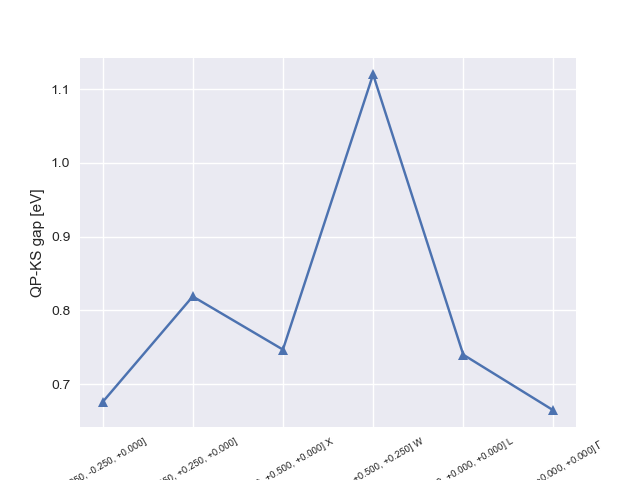

In [22]:
sigres.plot_qpgaps();

We can also visualize the difference between the QP and the KS values with: 

<IPython.core.display.Javascript object>


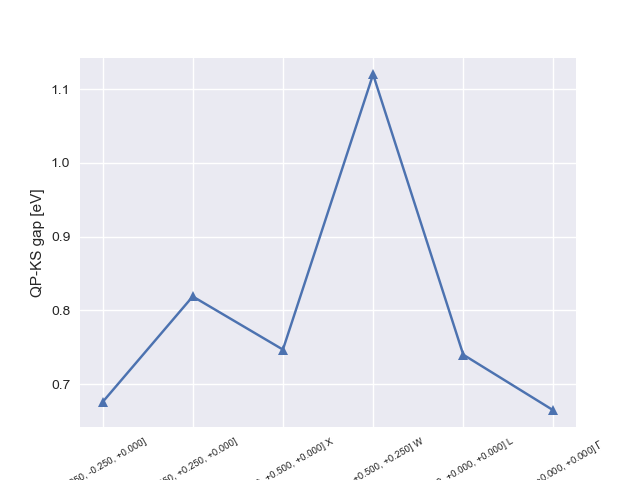

In [23]:
sigres.plot_qpgaps(plot_qpmks=True);

As expected, $G_0W_0$ leads to a systematic opening of the KS gaps although 
we should keep in mind that these results are far from being converged. 

<IPython.core.display.Javascript object>


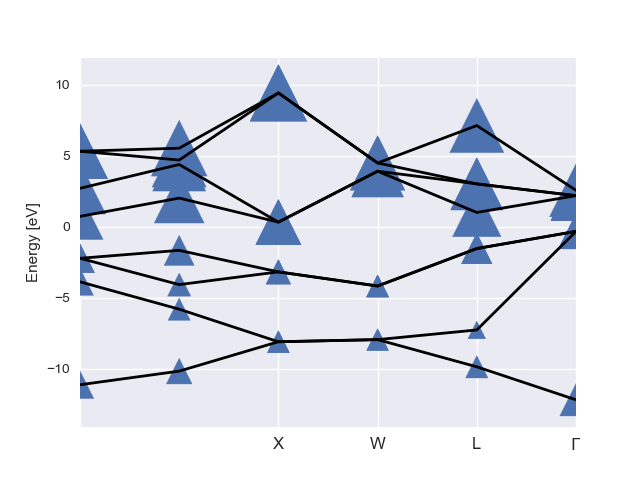

In [24]:
sigres.plot_ksbands_with_qpmarkers();

## Interpolating the QP corrections
[[back to top](#top)]

Excellent, we've just completed our first $GW$ calculation with Abinit and Abipy but there's still 
a problem that must be addressed!

We can only compute QP energies for k-points belonging to the k-mesh of the input WFK file while
we usually discuss electronic properties in terms of band energies along a high-symmetry k-path.
Obviously one could perform several different $GW$ calculations with "shifted" WFK files to collect 
the QP energies along the k-path but this is not the most efficient approach.
Can't we just use some kind of interpolation technique to get nice-looking QP band structures?

The answer is yes but remember to always **cross-check** the interpolated results.
Several different approaches to interpolate QP results have been proposed in the literature.
Here we use the Fourier interpolation scheme proposed by Shankland-Koelling-Wood (SKW) in PRB 38 2721.
The idea is relatively simple: the QP corrections have the same symmetry of the KS energies, we can thus
interpolate the QP corrections with SKW and then apply the interpolated corrections to the ab-initio KS energies
obtained along a path.

It's just a matter of passing the KS band structure to the `sigres.interpolate` method to activate this procedure: 

In [25]:
r = sigres.interpolate(lpratio=5, ks_ebands_kpath=ks_ebands_kpath)

Will use: 30 star-functions. nstars/nk: 5.0
FIT vs input data: Mean Absolute Error= 2.42861286636753e-13  [meV]


The interpolated QP band structure is available in `r.qp_ebands_kpath` and we can plot the interpolated data with:

<IPython.core.display.Javascript object>


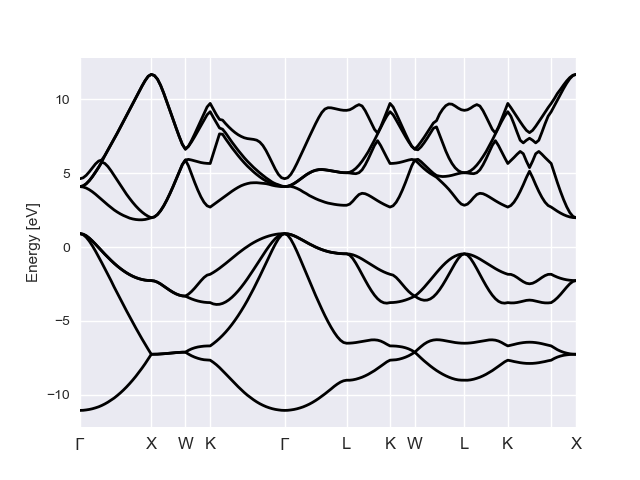

In [26]:
r.qp_ebands_kpath.plot();

The results make sense but it would be nice if one could compare the (interpolated) QP bands with the KS energies.
Fortunately, we can use the AbiPy `ElectronBandsPlotter` to compare multiple band structures:

<IPython.core.display.Javascript object>


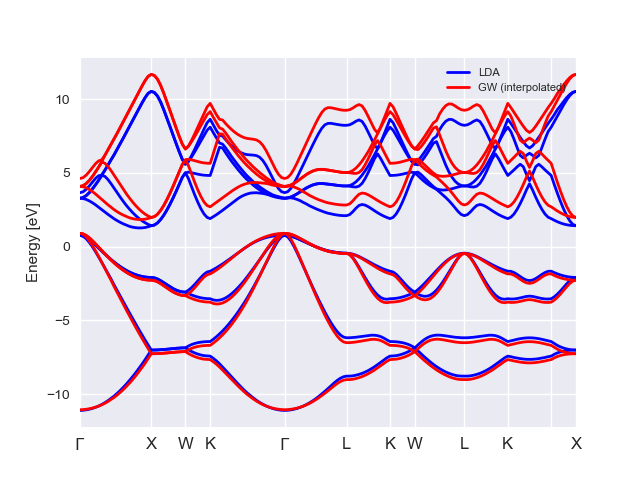

In [27]:
p = abilab.ElectronBandsPlotter()
p.add_ebands("LDA", ks_ebands_kpath)
p.add_ebands("GW (interpolated)", r.qp_ebands_kpath)
p.combiplot();

Do you need to compare the band dispersion given by KS and $GW$?

<IPython.core.display.Javascript object>


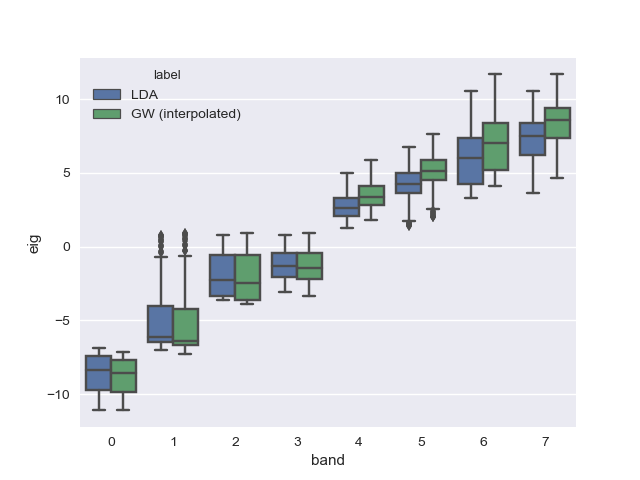

In [28]:
# By default, the two band energies are shifted wrt to *their* fermi level.
# Use e=0 if you don't want to shift the eigenvalus
# so that it's possible to visualize the QP corrections.
p.combiboxplot();

The same approach can be used to interpolate QP band structures and QP DOSes.
We only need to pass an additional KS band structure with energies in the IBZ:

In [29]:
r2 = sigres.interpolate(lpratio=5, ks_ebands_kpath=ks_ebands_kpath, ks_ebands_kmesh=ks_ebands_kmesh)

Will use: 30 star-functions. nstars/nk: 5.0
FIT vs input data: Mean Absolute Error= 2.42861286636753e-13  [meV]


and then compute the QP DOS with:

In [30]:
qp_edos = r2.qp_ebands_kmesh.get_edos()

Did I tell you that `ElectronBandsPlotter` accepts DOSes as well?

In [31]:
p2 = abilab.ElectronBandsPlotter()
p2.add_ebands("LDA", ks_ebands_kpath, dos=ks_edos)
p2.add_ebands("GW (interpolated)", r.qp_ebands_kpath, dos=qp_edos)

<IPython.core.display.Javascript object>


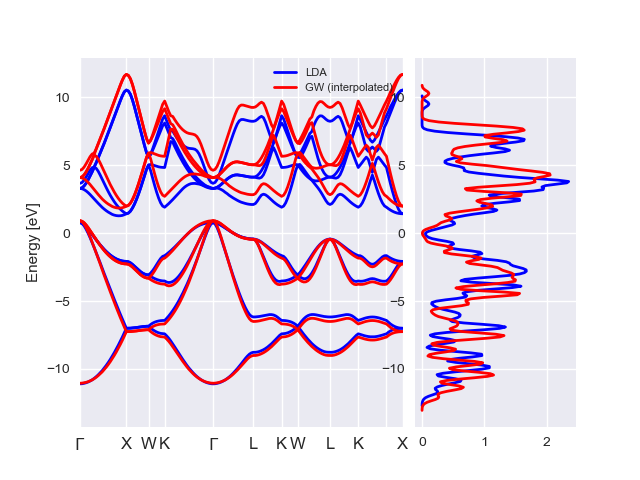

In [32]:
p2.combiplot();

<!-- A logical next lesson would be the 
[Bethe-Salpeter tutorial](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/bse/lesson_bse.ipynb)
-->

Back to the main [Index](../index.ipynb)